# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from scipy.ndimage import gaussian_filter


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Evaluating the first round of training of the ResNet 50 Model 
- To overcome the challenges faced in the first train of the model, such as overfitting and class imbalance, hence we will apply data augmentation, model regularisation and early stopping. 


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

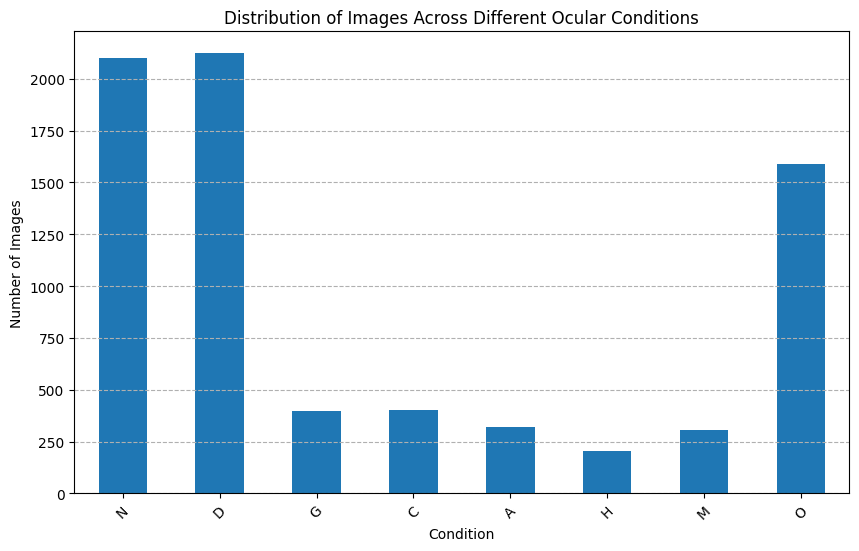

In [4]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [5]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [4]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

In [7]:
df_train.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2273,3159,62,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
5609,3315,57,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
4614,2152,58,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3658,542,64,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
471,540,82,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0,1,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


Filtering the Minority Classes

labels
['N']    2304
['D']    1275
['O']     572
['C']     235
['G']     223
['A']     220
['M']     184
['H']     100
Name: count, dtype: int64


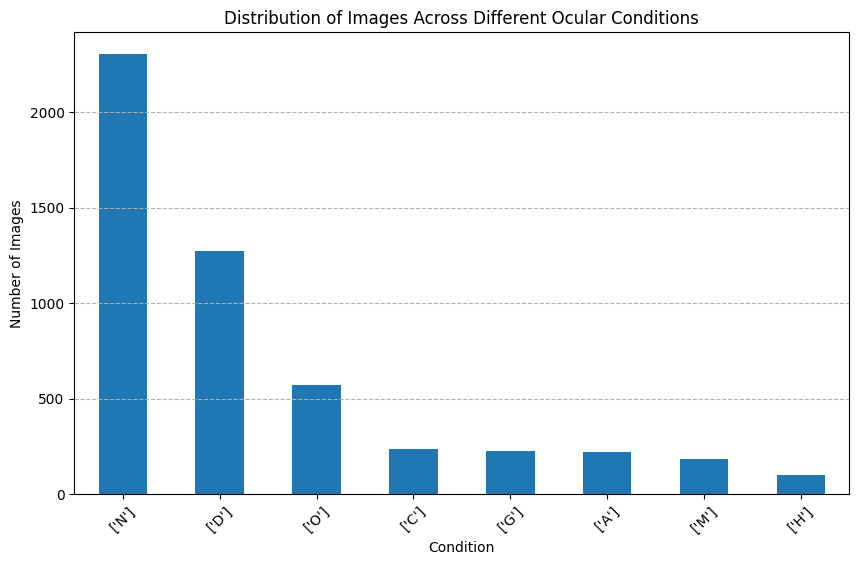

In [8]:
class_counts = df_train['labels'].value_counts()
print(class_counts)

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [9]:
import math

def calculate_augmentations_needed(current_distribution, target_count):
    # Calculate the augmentations needed for each class to reach the target count
    augmentations_needed_per_class = {
        class_label: target_count - count 
        for class_label, count in current_distribution.items() if count < target_count
    }
    
    # Calculate the total augmentations needed
    total_augmentations_needed = sum(augmentations_needed_per_class.values())
    
    # Calculate the average number of augmentations needed per image in each under-represented class
    augmentations_needed_per_image = {
        class_label: math.ceil(augmentations_needed / current_distribution[class_label])
        for class_label, augmentations_needed in augmentations_needed_per_class.items()
    }
    
    return augmentations_needed_per_image, total_augmentations_needed

# Use the function
current_distribution = {
    'N': 2304,
    'D': 1275,
    'G': 223,
    'C': 235,
    'A': 220,
    'H': 100,
    'M': 184,
    'O': 572
}
target_count = max(current_distribution.values())  # The target is the class with the maximum instances
augmentations_per_image, total_needed = calculate_augmentations_needed(current_distribution, target_count)

print(f"Augmentations needed per image (rounded up): {augmentations_per_image}")
print(f"Total augmentations needed (sum of rounded values): {total_needed}")



Augmentations needed per image (rounded up): {'D': 1, 'G': 10, 'C': 9, 'A': 10, 'H': 23, 'M': 12, 'O': 4}
Total augmentations needed (sum of rounded values): 13319


In [5]:

# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=5,         # Slightly reduce the rotation range
    zoom_range=0.05,          # Reduce the zoom range
    brightness_range=(0.95, 1.05), # Narrow the brightness range
    fill_mode='constant',     # Change fill mode to 'constant'
    cval=0,                   # Set constant value to 0 (black) which might be more appropriate for fundus images
    # Consider adding a shear range if it makes sense for your data
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# The augmentations_needed dictionary now uses numerical indices as keys
augmentations_needed = { 0:0, 1:1, 2:10, 3:9, 4:10, 5:23, 6:12, 7:4 }

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    img = img.resize((256, 256))  # Resize image if necessary
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []

    # Determine the number of augmentations needed based on the target
    # Determine the number of augmentations needed based on the target
    targets = eval(row['target']) if isinstance(row['target'], str) else row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    for i in range(max_augmentations_needed):
        for batch in augmentation.flow(x, batch_size=1, save_prefix='aug_', save_format='jpeg'):
            # Create a unique filename using class index and augmentation index
            unique_filename = f'aug_{i}_{row["filename"]}'
            # Generate the full path for saving
            augmented_image_path = os.path.join(save_directory, unique_filename)
            # Save the image to the full path
            save_img(augmented_image_path, batch[0])

            # Replicate the row and update the filename
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)

            break  # Only save one image per augmentation to avoid infinite loop

    return augmented_rows  # Return the augmented rows with updated filenames

# Usage with ThreadPoolExecutor
augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for _, row in df_train.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame(augmented_data)

# Concatenate the original DataFrame with the new augmented DataFrame
df_combined = pd.concat([df_train, df_augmented], ignore_index=True)


Augmenting Images:   0%|          | 0/5113 [00:00<?, ?it/s]

In [6]:
df_augmented.head()

# save to csv

df_augmented.to_csv('dataset\\df_augmented.csv', index=False)

In [7]:
df_combined.head()

# save to csv

df_combined.to_csv('dataset\\full_df_augmented.csv', index=False)

Class N: 2304
Class D: 2550
Class G: 2453
Class C: 2350
Class A: 2420
Class H: 2400
Class M: 2392
Class O: 2860


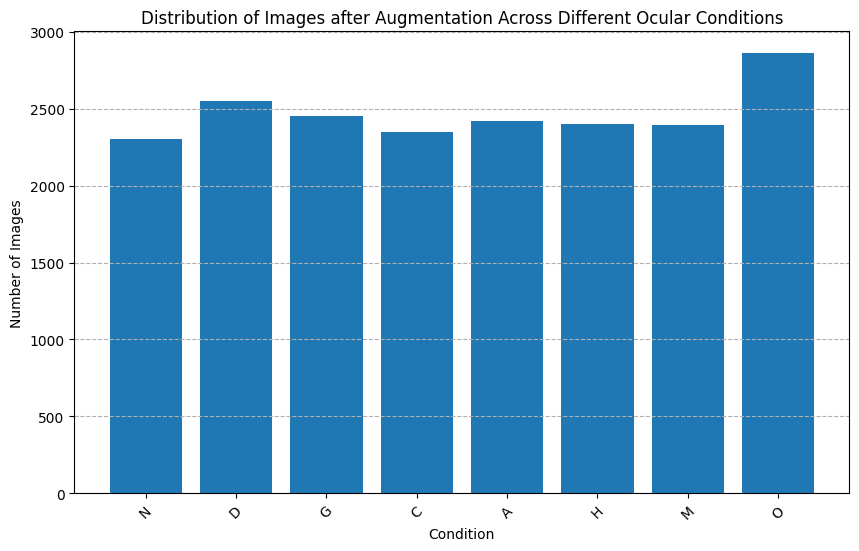

In [8]:
import ast
import numpy as np

# Convert string representation of list to actual list using ast.literal_eval
df_combined['target'] = df_combined['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_combined['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_combined['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')



In [9]:
datagen = ImageDataGenerator(
    validation_split=0.2
    
)



train_generator = datagen.flow_from_dataframe(
    dataframe= df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/', 
    x_col='filename',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/',
    x_col='filename',
    y_col='labels',
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 15784 validated image filenames belonging to 8 classes.
Found 3945 validated image filenames belonging to 8 classes.


In [10]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,  # Use the separate test DataFrame
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='labels',
    target_size=(224,224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False  # Typically, you don't want to shuffle the test set
)

Found 1279 validated image filenames belonging to 8 classes.


# Loading and Visualising the Training Data 

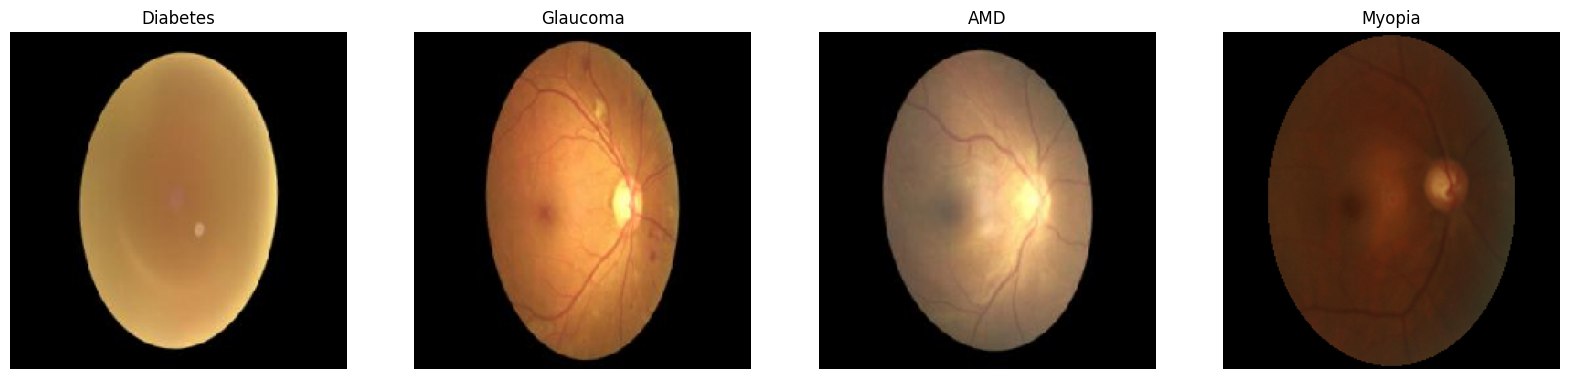

In [11]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
import tensorflow as tf

# Load the base pretrained model
pretrained_model = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='imagenet')

# Unfreeze the last few layers of the model
for layer in pretrained_model.layers[:-10]:
    layer.trainable = False
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

# Create the model
model = Sequential([
    pretrained_model,
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dense(8, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), #0.0001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Checkpoint
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)

# TensorBoard
tensorboard = TensorBoard(log_dir='./logs')



In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,649,096
Trainable params: 4,473,864
Non-trainable params: 20,175,232
__________________________________

In [17]:
# Train the model
history = model.fit(train_generator, 
                    epochs=50, #50
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=[reduce_lr, early_stopping, checkpoint, tensorboard])

Epoch 1/50
493/493 [==============================] - ETA: 0s - loss: 1.1098 - accuracy: 0.6505
Epoch 1: val_loss improved from inf to 1.25743, saving model to model_best.h5
493/493 [==============================] - 186s 359ms/step - loss: 1.1098 - accuracy: 0.6505 - val_loss: 1.2574 - val_accuracy: 0.5447 - lr: 1.0000e-04
Epoch 2/50
493/493 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8305
Epoch 2: val_loss improved from 1.25743 to 1.14336, saving model to model_best.h5
493/493 [==============================] - 115s 233ms/step - loss: 0.5580 - accuracy: 0.8305 - val_loss: 1.1434 - val_accuracy: 0.5783 - lr: 1.0000e-04
Epoch 3/50
493/493 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8968
Epoch 3: val_loss improved from 1.14336 to 1.08404, saving model to model_best.h5
493/493 [==============================] - 116s 235ms/step - loss: 0.3724 - accuracy: 0.8968 - val_loss: 1.0840 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 4/50
493

# Evaluating Model 

Model Accuracy Graph Analysis

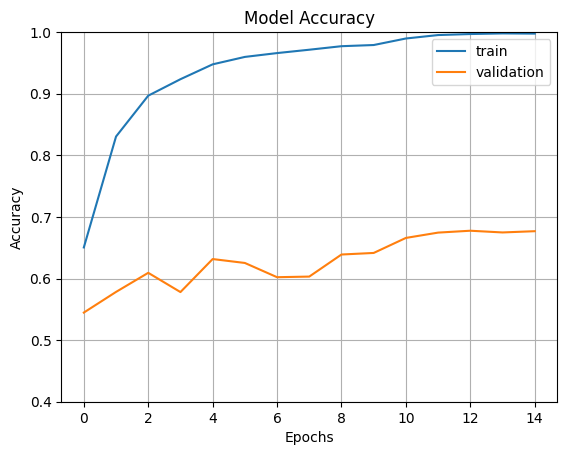

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

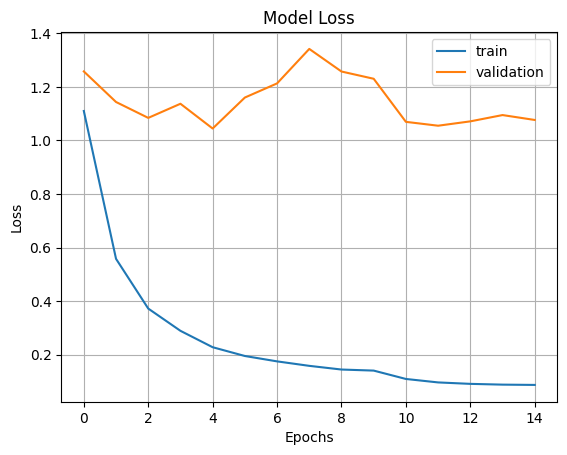

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [21]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


40/40 [==============================] - 16s 401ms/step


# Predictions Result Evaluation

In [22]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [23]:

# Get the true classes from the DataFrame
true_classes = test_generator.classes


# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.21      0.13      0.16        46
      Diabetes       0.67      0.76      0.71        58
      Glaucoma       0.44      0.42      0.43       333
      Cataract       0.36      0.21      0.27        61
           AMD       0.22      0.07      0.11        28
  Hypertension       0.80      0.81      0.80        48
        Myopia       0.56      0.72      0.63       569
Other diseases       0.24      0.07      0.11       136

      accuracy                           0.52      1279
     macro avg       0.44      0.40      0.40      1279
  weighted avg       0.48      0.52      0.49      1279



Balanced Accuracy Score 

In [24]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4007


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [25]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.7893


Confusion Matrix 

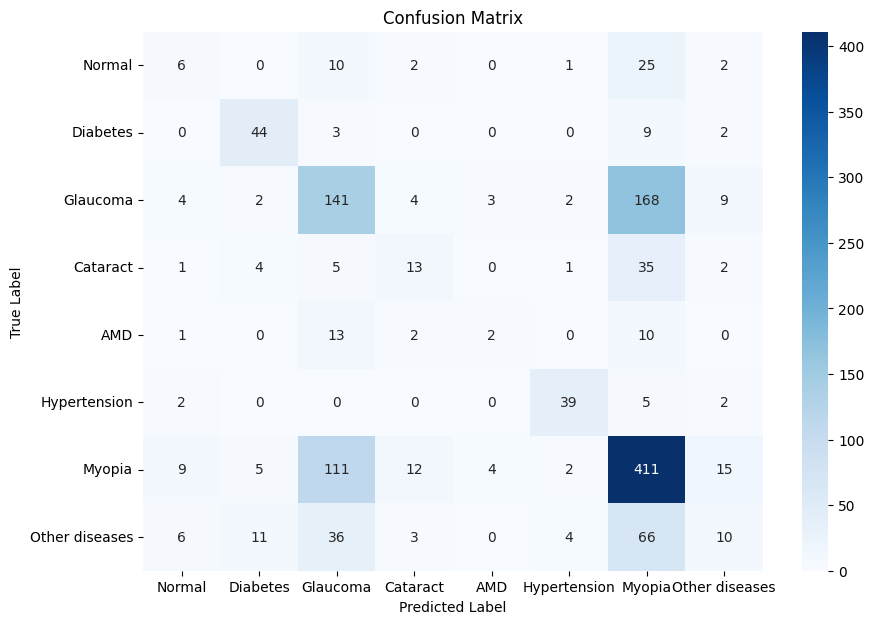

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

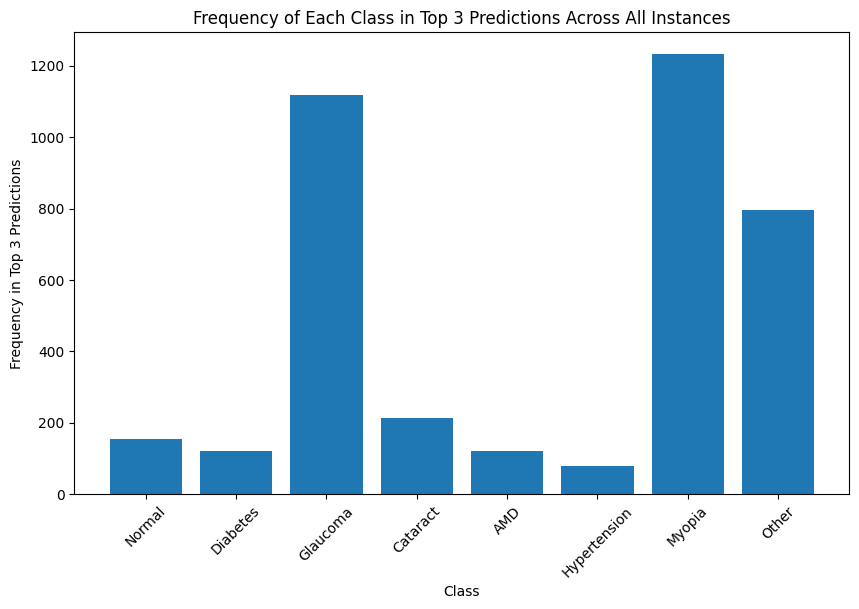

In [27]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')